## Aditya Jindal
## Batch W6
## Assignment11
## Applying Concepts Learned till now:
- ### CutOut 
- ### LR Finder
- ### SDG with Momentum
- ### GradCAM 
- ### Misclassification

In [1]:
# Importing Libraries

from keras import backend as K
import time
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import *
from keras.utils import np_utils
from keras.layers import Input
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

170500096/170498071 [==============================] - 3s 0us/step
10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


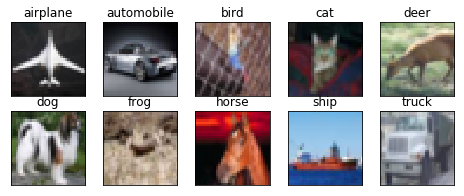

In [3]:
# Printing mentioned classes samples

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()



In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [21]:
# Define the model

kernel_l2 = 1e-4

input = Input(shape=(32,32,3))

ConvL1 = Conv2D(32,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(input)
# Input for Layer 1 = (32x32x3)
# RF = 3
BNL1 = BatchNormalization()(ConvL1)

ConvL2 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BNL1)
# Input for Layer 2 = (32x32x32)
# RF = 5
BNL2 = BatchNormalization()(ConvL2)

MPL1 = MaxPooling2D(pool_size=(2, 2))(BNL2)
# Input for BottleNeck Layer 11 = (32x32x64)
# RF = 10
DL1 = Dropout(0.2)(MPL1)

ConvPoint1 = Conv2D(32,(1, 1))(DL1)
# Input for BottleNeck Layer 12 = (16x16x64)
# RF = 10

ConvL3 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(ConvPoint1)
# Input for Layer 3 = (16x16x32)
# RF = 12
BNL3 = BatchNormalization()(ConvL3)

ConvL4 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BNL3)
# Input for Layer 4 = (16x16x64)
# RF = 14
BNL4 = BatchNormalization()(ConvL4)

MPL2 = MaxPooling2D(pool_size=(2, 2))(BNL4)
# Input for BottleNeck Layer 21 = (16x16x128)
# RF = 28
DL2 = Dropout(0.3)(MPL2)

ConvPoint2 = Conv2D(32,(1, 1))(DL2)
# Input for BottleNeck Layer 22 = (8x8x128)
# RF = 28

ConvL5 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(ConvPoint2)
BNL5 = BatchNormalization()(ConvL5)
# Input for Layer 5 = (8x8x32)
# RF = 30

ConvL6 = Conv2D(256,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(BNL5)
BNL6 = BatchNormalization()(ConvL6)
# Input for Layer 6 = (8x8x128)
# RF = 32

MPL3 = MaxPooling2D(pool_size=(2, 2))(BNL6)
# Input for BottleNeck Layer 31 = (8x8x256)
# RF = 64
DL3 = Dropout(0.5)(MPL3)

ConvPoint3 = Conv2D(10,(1, 1))(DL3)
# Input for BottleNeck Layer 32 = (4x4x256)
# RF = 64

APL1 = AveragePooling2D(pool_size = (4,4))(ConvPoint3)
# Input for A.Pool Layer 1 = (4x4x10)

FlatL = Flatten()(APL1)
# Input for Layer 8 = (1x1x10)

output = Activation('softmax')(FlatL)
# Input for Out Layer = (,10)

#Initialising the Model
model_LR_test = Model(inputs=[input], outputs=[output])
model_LR_final = Model(inputs=[input], outputs=[output])
model_LR_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
__________

In [8]:
#Mounting drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Defining Random Eraser function for CUTOUT Augmentation

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        
        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


In [0]:
#Image Normalisation and Applying Cutout Augmentation
#Create generator that centers pixel values

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

#compute std, mean required for featurewise normalization
datagen.fit(train_features)

In [11]:
# Compile the model
model_LR_test.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

weights_path="/content/gdrive/My Drive/EVA_Weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(weights_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only = False, period = 1)

W0717 17:19:24.410938 140667019061120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Defining LR Finder
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])


In [0]:
# Initialising LR_Finder

lr_finder = LR_Finder(start_lr=1e-6, end_lr=1, step_size=np.ceil(train_features.shape[0]//256))

In [14]:
# Train the model with cutout augmentation and LR_FINDER and verbose is 0
start = time.time()
model_tuned = model_LR_test.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 steps_per_epoch = train_features.shape[0]//256, epochs = 1, 
                                 validation_data = (test_features, test_labels), verbose=0, callbacks = [checkpoint, lr_finder])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

W0717 17:19:38.454871 140667019061120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-01-0.10.hdf5
Model took 17.16 seconds to train


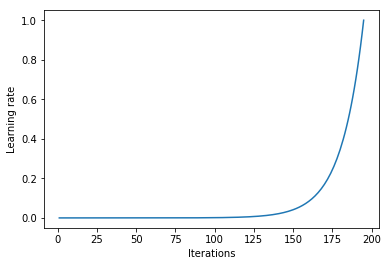

In [15]:
# Plotting LR vs Iterations
lr_finder.plot_lr()


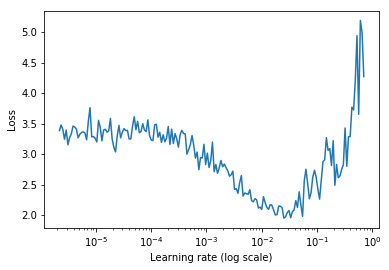

In [16]:
# Plotting Loss vs LR

lr_finder.plot()

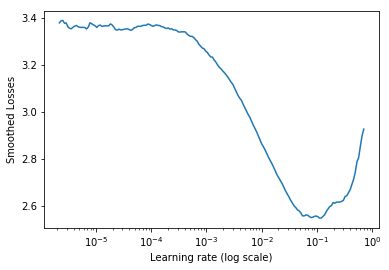

In [17]:
# Plotting Smooth Losses vs LR

lr_finder.plot_smoothed_loss()

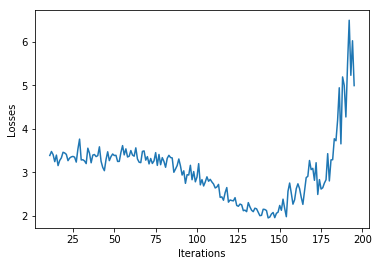

In [18]:
# Plotting Losses vs Iterations

lr_finder.plot_loss()

### Based on the Graph w.r.t LR and Losses, we infer that our best starting learning rate for training can be between the range of
### 0.5e-2 to 0.5e-1. 
### Therefore i'll take 1e-2 as the start LR

In [0]:
# Compile the model
model_LR_final.compile(optimizer=SGD(lr=1e-2, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

weights_path="/content/gdrive/My Drive/EVA_Weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(weights_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only = False, period = 1)


Epoch 00001: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-01-0.26.hdf5

Epoch 00002: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-02-0.23.hdf5

Epoch 00003: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-03-0.21.hdf5

Epoch 00004: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-04-0.26.hdf5

Epoch 00005: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-05-0.21.hdf5

Epoch 00006: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-06-0.25.hdf5

Epoch 00007: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-07-0.24.hdf5

Epoch 00008: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-08-0.31.hdf5

Epoch 00009: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-09-0.27.hdf5

Epoch 00010: saving model to /content/gdrive/My Drive/EVA_Weights/weights-improvement-10-0.30.hdf5


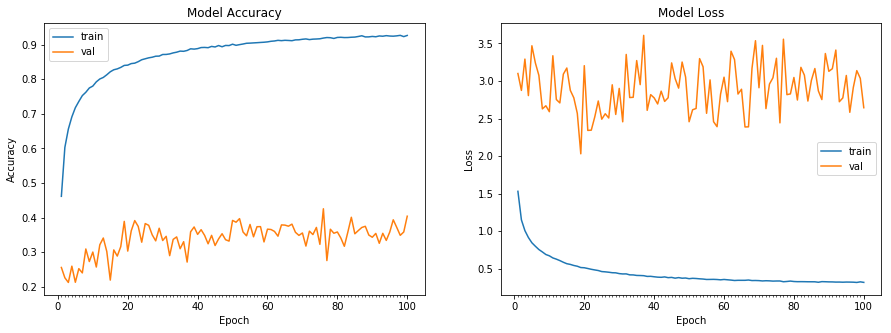

Accuracy on test data is: 40.40 


In [23]:
# Train the model with cutout augmentation and the best LR found and verbose is 0
start = time.time()
model_info_tuned = model_LR_final.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]//128, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=0, callbacks = [checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_LR_final))

In [25]:
model_LR_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
__________

In [0]:
# GradCam function to create heatmap superimposed images with original images

def gradCam(img, layerName, out_channels):
  img1 = np.expand_dims(img, axis=0)
  
  preds = model_LR_final.predict(img1)
  class_idx = np.argmax(preds[0])
  class_output = model_LR_final.output[:, class_idx]
  last_conv_layer = model_LR_final.get_layer(layerName)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_LR_final.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img1])
  for i in range(out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255 * img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  cv2.waitKey(0)
  
  return superimposed_img

5960  incorrect classification


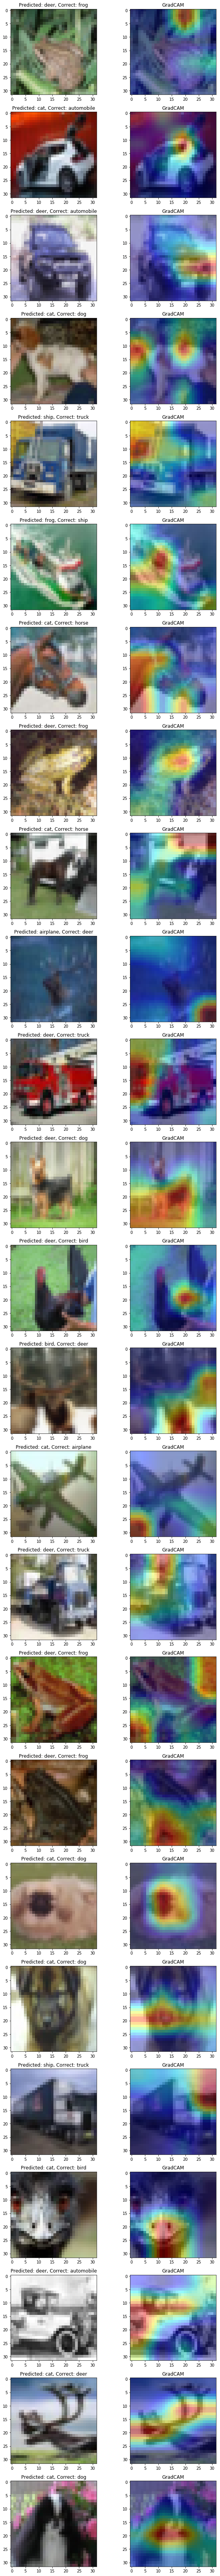

In [44]:
# Gallery for 25 misclassified class images and displaying their gradCAM results

model_pred = model_LR_final.predict(test_features)
pred_classes = np.argmax(model_pred, axis = 1)

# getting incorrect indices
incorrect_indices = np.nonzero(pred_classes != np.nonzero(test_labels)[1])[0]

print(len(incorrect_indices)," incorrect classification")

fig, ax = plt.subplots(25, 2, figsize = (10, 120))

for num, incorrect in enumerate(incorrect_indices[:25]):
    grad_img = gradCam(test_features[incorrect], "conv2d_18", 10)
    ax[num,0].set_title("Predicted: {}, Correct: {}".format(class_names[pred_classes[incorrect]],
                                                            class_names[np.argmax(test_labels, axis = 1)[incorrect]])) 
                                       
    ax[num,0].imshow(test_features[incorrect])
    ax[num,1].set_title("GradCAM")
    ax[num,1].imshow(grad_img)
plt.show()